## Etapa de División de la data en Train y Validation ##
En esta etapa se divide la data de botellas en Train y Validation

In [1]:
import os
import shutil
import random

def split_dataset(dataset_dir, output_dir, split_ratio=0.8):
    """
    Divide el conjunto de datos en entrenamiento y prueba.

    :param dataset_dir: Directorio que contiene las carpetas 'red' y 'yellow'.
    :param output_dir: Directorio donde se guardarán los datos divididos.
    :param split_ratio: Proporción de datos para entrenamiento (el resto será para prueba).
    """
    # Crear directorios de salida
    train_dir = os.path.join(output_dir, 'train')
    validation_dir = os.path.join(output_dir, 'validation')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    
    categories = ['glass', 'plastic']
    
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)
        images = os.listdir(category_dir)
        random.shuffle(images)
        
        train_size = int(len(images) * split_ratio)
        train_images = images[:train_size]
        validation_images = images[train_size:]
        
        train_category_dir = os.path.join(train_dir, category)
        validation_category_dir = os.path.join(validation_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(validation_category_dir, exist_ok=True)
        
        for img in train_images:
            src = os.path.join(category_dir, img)
            dst = os.path.join(train_category_dir, img)
            shutil.copy(src, dst)
        
        for img in validation_images:
            src = os.path.join(category_dir, img)
            dst = os.path.join(validation_category_dir, img)
            shutil.copy(src, dst)
    
    print("Datos divididos y copiados correctamente.")

# Uso de la función

dataset_dir = './classification-of-bottles-1' #Cambiar por la dirección de la carpeta que contiene las imagenes
output_dir = './classification-of-bottles-1_div' #Ustedes definen la dirección y el nombre del archivo
split_dataset(dataset_dir, output_dir, split_ratio=0.8)

Datos divididos y copiados correctamente.


## Etapa de Creación de la arquitectura ##
En esta etapa se crea la arquitectura de la red neuronal

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Para clasificación binaria (glass, plastic)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2025-10-01 18:39:51.087220: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 18:39:51.087897: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 18:39:51.135948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 18:39:52.728604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Etapa de Acondicionamiento de la data ##
En esta etapa se hace un redimensionamiento a las imagenes a 64x64 pixeles asi como la definición del batch size

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
output_dir = 'classification-of-bottles-1_div' # Aqui se debe colocar la dirección del dataset dividido en train y validation
train_set = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(64, 64), #Dimensiones requeridas
    batch_size=32,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    os.path.join(output_dir, 'validation'),
    target_size=(64, 64), #Dimensiones requeridas
    batch_size=32,
    class_mode='categorical'
)



Found 275 images belonging to 2 classes.
Found 137 images belonging to 2 classes.


## Etapa de Entrenamiento ##
Se entrena el modelo

In [4]:
model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=100,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size
)

# Evaluación
loss, accuracy = model.evaluate(validation_set)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


/home/david/dev/pucp/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5720 - loss: 0.7233 - val_accuracy: 0.5703 - val_loss: 0.6745
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5625 - loss: 0.6786 - val_accuracy: 0.5781 - val_loss: 0.6716
Epoch 3/100


/home/david/dev/pucp/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6049 - loss: 0.6620 - val_accuracy: 0.5625 - val_loss: 0.6695
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3438 - loss: 0.7866 - val_accuracy: 0.5859 - val_loss: 0.6564
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5802 - loss: 0.6521 - val_accuracy: 0.5859 - val_loss: 0.6295
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5312 - loss: 0.6471 - val_accuracy: 0.5781 - val_loss: 0.6236
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6420 - loss: 0.6424 - val_accuracy: 0.7656 - val_loss: 0.5952
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.6419 - val_accuracy: 0.7188 - val_loss: 0.6049
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6955 - loss: 0.6065 - val_accuracy: 0.5859 - val_loss: 0.6114
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5625 - loss: 0.6127 - val_accuracy: 0.6016 - val_loss: 0.5916
Epo

A continuación se construye la matriz de confusión del modelo entrenado

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


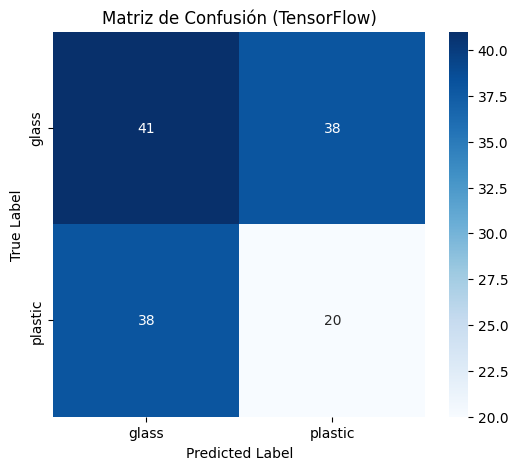

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener predicciones (probabilidades) para el conjunto de validación
predictions = model.predict(validation_set, verbose=1)

# Convertir probabilidades en etiquetas predichas
y_pred = tf.argmax(predictions, axis=1).numpy()

# Etiquetas verdaderas
y_true = validation_set.classes  # Vienen directamente del generador

# Obtener número de clases
num_classes = len(validation_set.class_indices)

# Crear matriz de confusión vacía
confusion_mtx = np.zeros((num_classes, num_classes), dtype=np.int32)

# Rellenar matriz de confusión
for true_label, pred_label in zip(y_true, y_pred):
    confusion_mtx[true_label][pred_label] += 1

# Nombres de clases (ordenados según el generador)
class_names = list(validation_set.class_indices.keys())

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión (TensorFlow)")
plt.show()


## Etapa de uso del modelo de entrenado ##


In [7]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Diccionario de clases (ajustar si fue entrenado con más o diferentes clases)
class_indices = {'glass': 0, 'plastic': 1}
class_labels = {v: k for k, v in class_indices.items()}  # Invertimos para obtener nombre desde índice

def predict_image(img_path, model, class_labels):
    try:
        # Cargar y preprocesar la imagen
        img = image.load_img(img_path, target_size=(64, 64))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # (1, 64, 64, 3)
        img_array /= 255.0

        # Hacer la predicción
        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction)
        predicted_label = class_labels[predicted_index]
        confidence = prediction[0][predicted_index]

        return f'Predicción: {predicted_label} (Confianza: {confidence:.2f})'
    except Exception as e:
        return f'Error al procesar la imagen: {e}'

# Ruta de la imagen individual que deseas probar
img_path = "/home/david/dev/pucp/classification-of-bottles-1_div/validation/glass/naver_0214_jpg.rf.748c215256e241385605dcc5471007a2.jpg"
print(predict_image(img_path, model, class_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicción: glass (Confianza: 1.00)


Se exporta el modelo con el formato .h5

In [81]:
model.save("./modelo.h5")